In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
df = pd.read_csv("../../data/Salary_Data.csv")


In [66]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [68]:
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [69]:
print(df.isnull().sum())

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [70]:
df.loc[df.duplicated()]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
250,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
251,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
252,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
253,28.0,Male,Bachelor's,Junior Business Development Associate,2.0,40000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [71]:
df.dropna(inplace=True)

In [72]:
df_copy = df.copy()
df_copy.loc[len(df)] = df.loc[len(df) - 1]

In [73]:
df_copy.loc[df_copy.duplicated()]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
250,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
251,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
252,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
253,28.0,Male,Bachelor's,Junior Business Development Associate,2.0,40000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [74]:
df_copy.tail()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0
6703,26.0,Female,High School,Sales Executive,1.0,35000.0


In [75]:
print(df.describe())

               Age  Years of Experience         Salary
count  6698.000000          6698.000000    6698.000000
mean     33.623022             8.095178  115329.253061
std       7.615784             6.060291   52789.792507
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000


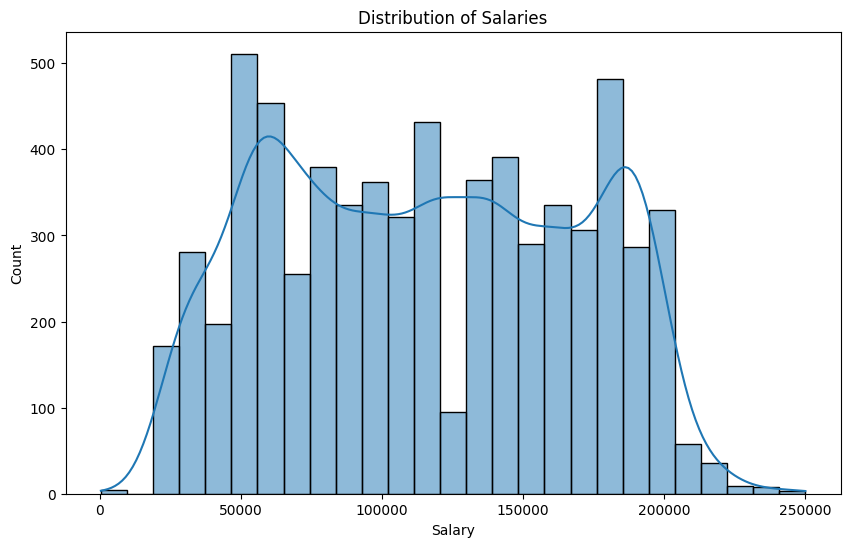

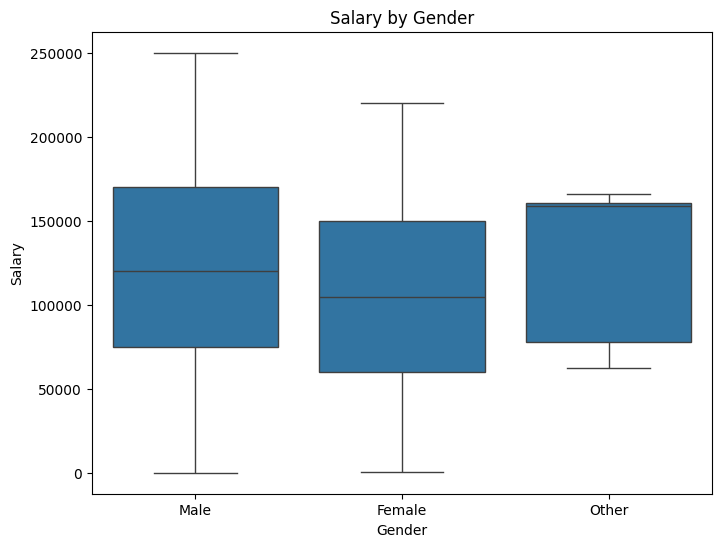

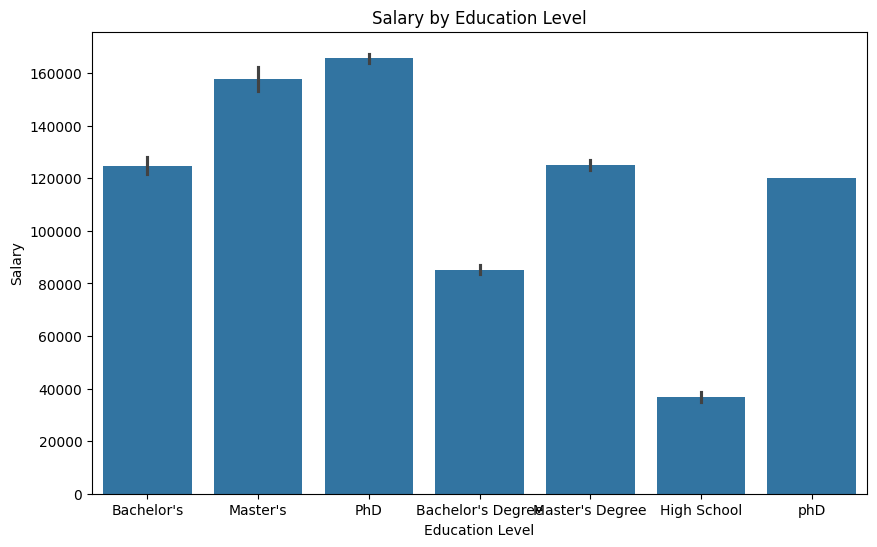

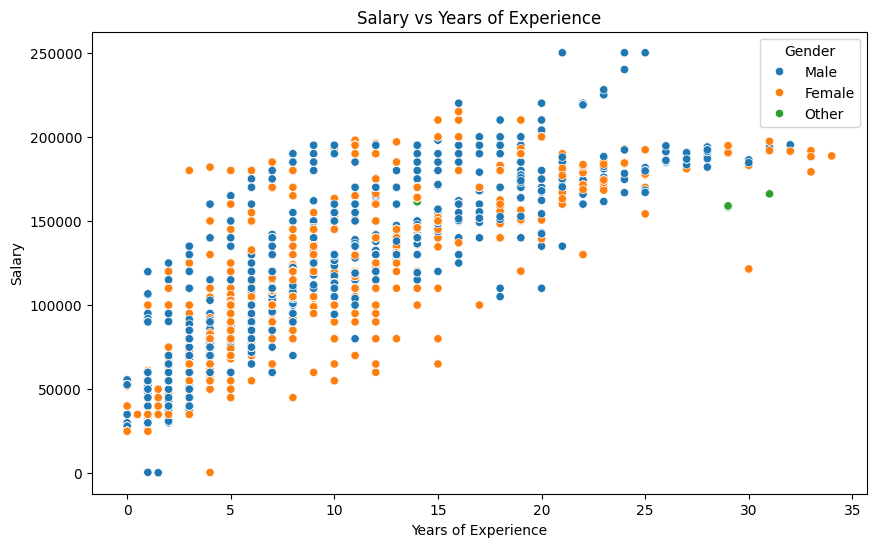

['Age', 'Years of Experience', 'Salary']


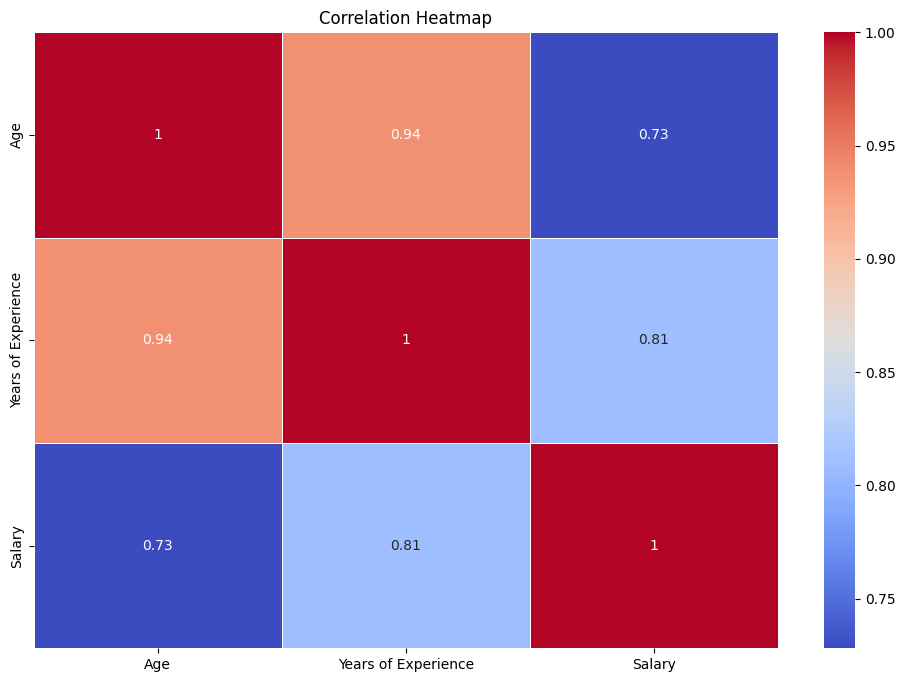

In [76]:
plt.figure(figsize=(10,6))
sns.histplot(df['Salary'], kde=True)
plt.title('Distribution of Salaries')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title('Salary by Gender')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Education Level', y='Salary', data=df)
plt.title('Salary by Education Level')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='Years of Experience', y='Salary', hue='Gender', data=df)
plt.title('Salary vs Years of Experience')
plt.show()

numerical_features = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_features)
cor_matrix= df[numerical_features].corr()
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [77]:
X = df.drop('Salary', axis=1)
y = df['Salary']

In [78]:
categorical_cols = ['Gender', 'Education Level', 'Job Title']
numerical_cols = ['Age', 'Years of Experience']

In [79]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

In [80]:
threshold = 10

top_jobs = df['Job Title'].value_counts().loc[lambda x: x >= threshold].index
df['Job Title'] = df['Job Title'].where(df['Job Title'].isin(top_jobs), other='Other')

top_edu = df['Education Level'].value_counts().loc[lambda x: x >= threshold].index
df['Education Level'] = df['Education Level'].where(df['Education Level'].isin(top_edu), other='Other')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [83]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [84]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [85]:
def evaluate(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} RMSE: {rmse:.2f}")
    print(f"{dataset_name} R²: {r2:.2f}")

evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Testing")

Training RMSE: 3720.81
Training R²: 1.00
Testing RMSE: 7086.02
Testing R²: 0.98


In [91]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [94]:
cv_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
print("Cross-Validation RMSE (mean):", -np.mean(cv_scores))

Cross-Validation RMSE (mean): 23342.987363290922


In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__min_samples_split': [2, 5], 'regressor__n_estimators': [100, 200]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [93]:
new_data = pd.DataFrame({
    'Age': [30],
    'Gender': ['Female'],
    'Education Level': ['Master\'s'],
    'Job Title': ['Data Analyst'],
    'Years of Experience': [4]
})

In [89]:
predicted_salary = model.predict(new_data)
print(f"Predicted Salary: ${predicted_salary[0]:,.2f}")

Predicted Salary: $117,266.67
